### Simulator

In [18]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl
import seaborn as sns
import torch
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

  0%|          | 0/10000 [00:00<?, ?it/s]

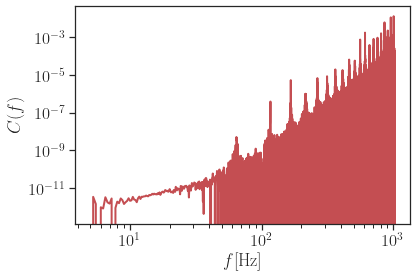

In [19]:
# Simulate data 

fref = 25
CE_PSD = np.genfromtxt("./cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("./gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([-11, 1.5])})
samples = sim.sample(10_000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)
plt.xlabel(r"$f$[Hz]")
plt.ylabel(r"$C(f)$")
plt.show()

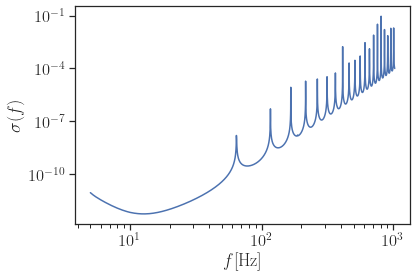

In [20]:
plt.loglog(sim.freq, samples[5]['sigma'])
plt.xlabel(r"$f$[Hz]")
plt.ylabel(r"$\sigma(f)$")
plt.show()

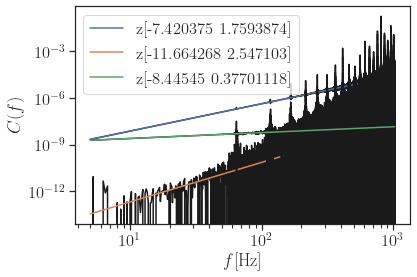

In [21]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.xlabel(r"$f$[Hz]")
plt.ylabel(r"$C(f)$")
plt.legend()
plt.show()

In [22]:
samples['x'].shape

(10000, 4076)

##  Autoencoder


In [23]:
import torch.nn as nn
from torchsummary import summary
DEVICE = 'GPU'
# Define Autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4076, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 16),
  
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.GELU(),
            nn.Linear(64, 256),
            nn.GELU(),
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Linear(512,1024),
            nn.GELU(),
            nn.Linear(1024,2048),
            nn.GELU(),
            nn.Linear(2048,4076),
        )



    def forward(self, x):
        x = self.encoder(x)
        #x = self.dropout(x)
        x = self.decoder(x)
        return x



model = Autoencoder()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]       8,349,696
              GELU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              GELU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              GELU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              GELU-8               [-1, 1, 256]               0
            Linear-9                [-1, 1, 64]          16,448
             GELU-10                [-1, 1, 64]               0
           Linear-11                [-1, 1, 16]           1,040
           Linear-12                [-1, 1, 64]           1,088
             GELU-13                [-1, 1, 64]               0
           Linear-14               [-1,

In [31]:
# Pre-Process Data
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = np.log10(np.abs(samples['x']))
m_samples = np.log10(np.abs(samples['m']))


# Standardize x first might help
# No need to scale m--parameters
scaler_x = StandardScaler() 
scaler_m = StandardScaler() 
x_scaled = scaler_x.fit_transform(x_samples)
m_scaled = scaler_x.fit_transform(x_samples)

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1) # x_scaled, m_scaled

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

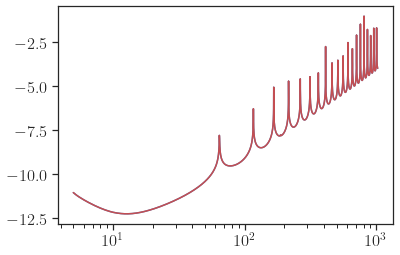

In [33]:
# Getting variance in each dimension of data
# def Var_By_Column(data):
    
#     sigma = np.zeros(len(data[0,:]))

#     for i in range(len(sigma)):
#         sigma[i] = np.var(data[:,i])

#     return sigma

sig_test = np.log10(sim.sigma())#Var_By_Column(x_test)
sig_train = np.log10(sim.sigma())# Var_By_Column(x_train)

plt.semilogx(sim.freq, sig_test)
plt.semilogx(sim.freq, sig_train, c="r")
plt.show()

In [34]:
# Define weighted loss function
def MSELoss_Weighted(sigma, predictions, targets):
    """""
    Computes the mean squared error (MSE) loss between predictions and targets, 
    weighted by the variance of the dimension
    
    Args:
        predictions (torch.Tensor): The predicted values.
        targets (torch.Tensor): The target values.
        
    Returns:
        torch.Tensor: The computed MSE loss.
    """
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    sigma = torch.Tensor(sigma)
    
    squared_error = torch.sum(sigma**2*(predictions - targets)**2, axis=0) # * (predictions - targets)**2 
    
    mse_loss = torch.mean(squared_error)
    
    return mse_loss

In [35]:
# Autoencoder
num_epochs = 20
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # try smaller lr
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=num_epochs)
train_losses = []
test_losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("lr=", optimizer.param_groups[0]["lr"])
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        #loss = criterion(outputs, targets.unsqueeze(1))  
        loss = MSELoss_Weighted(sig_train, outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.unsqueeze(1)) 
            #test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
            test_loss += MSELoss_Weighted(sig_test,outputs, targets.unsqueeze(1)).item() * inputs.size(0)
        

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss:.4f}")

lr= 0.0001
Epoch [1/20], Loss: 543.4776071303
Test Loss: 438.3172
lr= 9.505e-05
Epoch [2/20], Loss: 429.9473810154
Test Loss: 416.4183
lr= 9.010000000000001e-05
Epoch [3/20], Loss: 415.4825130547
Test Loss: 408.2688
lr= 8.515000000000001e-05
Epoch [4/20], Loss: 411.7459102919
Test Loss: 406.3982
lr= 8.020000000000001e-05
Epoch [5/20], Loss: 410.9146756795
Test Loss: 406.0027
lr= 7.525000000000001e-05
Epoch [6/20], Loss: 410.5023265788
Test Loss: 405.3326
lr= 7.030000000000001e-05
Epoch [7/20], Loss: 409.9212855089
Test Loss: 405.6071
lr= 6.535000000000002e-05
Epoch [8/20], Loss: 409.9232924669
Test Loss: 404.7632
lr= 6.040000000000001e-05
Epoch [9/20], Loss: 409.4278331095
Test Loss: 404.6523
lr= 5.545000000000001e-05
Epoch [10/20], Loss: 409.2999307454
Test Loss: 404.5946
lr= 5.050000000000001e-05
Epoch [11/20], Loss: 409.0762657267
Test Loss: 404.4106
lr= 4.555000000000001e-05
Epoch [12/20], Loss: 408.8008803033
Test Loss: 404.2630
lr= 4.0600000000000004e-05
Epoch [13/20], Loss: 408.

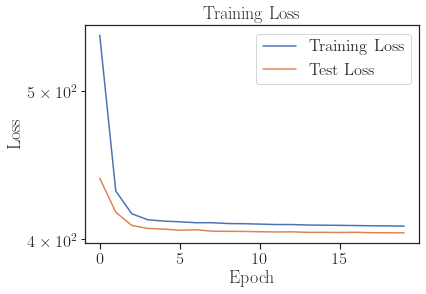

In [36]:
plt.semilogy(train_losses, label='Training Loss')
plt.semilogy(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

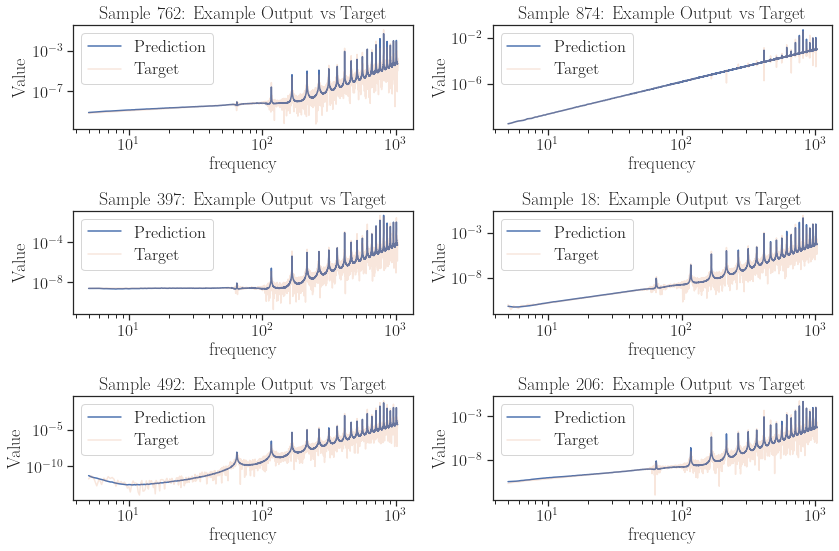

In [54]:
import random

# Randomly select 6 indices
num_samples = 6
random_indices = random.sample(range(len(test_dataset)), num_samples)

# unstandardize
mu = np.mean(x_samples, axis=0)
sigma = np.std(x_samples, axis=0)

# Calculate the number of rows and columns for the subplot layout
num_rows = 3
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction = model(sample.unsqueeze(0).unsqueeze(0)) 

    axs[row, col].loglog(sim.freq, 10**(prediction.squeeze().numpy()*sigma + mu), label='Prediction')
    axs[row, col].loglog(sim.freq, 10**(target.squeeze().numpy()*sigma+mu),  label='Target', alpha=0.2)
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: Example Output vs Target')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [43]:
np.mean(x_test, axis=0), np.std(x_test, axis=0),np.mean(x_scaled,  axis=0), np.std(x_scaled,  axis=0)

(array([ 0.01598686,  0.00369507,  0.01033385, ...,  0.05504164,
         0.03850761, -0.00559453], dtype=float32),
 array([0.9840095 , 0.9965789 , 0.98302674, ..., 0.9787599 , 1.0121988 ,
        0.98305804], dtype=float32),
 array([-9.8824504e-09,  1.4665723e-08, -1.6361476e-09, ...,
         1.2264028e-08,  1.4173985e-08,  8.4817406e-09], dtype=float32),
 array([0.9999992 , 0.99999845, 0.99999994, ..., 1.0000002 , 1.0000001 ,
        0.9999995 ], dtype=float32))